**Reto MicroscopIA**

**Clasificación de Histopatología de Cáncer de Pulmón**

**María Alejandra Pérez Petro**


**Datos:** Los datos los puedes consultar [aquí](https://drive.google.com/file/d/1vHpktP4M3uQOoh_QlBAqcvC111o8e5ef/view).

# **Librerias**

In [1]:
# Instalación de librerías
#!pip install keras-tuner -q
#!pip install scikit-learn -q
#!pip install tensorflow -q

In [50]:
# IMPORTAR LIBRERÍAS

# Numpy, Dataframes y visualización
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2


# Sklearn
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Keras y sus módulos
import tensorflow as tf
from tensorflow import keras
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, AveragePooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.applications import InceptionResNetV2 # red preentrenada


# otros
import json
import os
import shutil
import yaml
from pathlib import Path
from glob import glob

Definimos semilla para la reproducibilidad

In [23]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# **1. Introducción a las imagenes**

In [59]:
ROOT_DIR = Path.cwd()  # Directorio raíz del proyecto
DATA_DIR = ROOT_DIR.parent / 'data'  # Directorio de datos
MODELS_DIR = ROOT_DIR.parent / 'models'  # Directorio de modelos
DATA_DIR

WindowsPath('c:/Users/maril/Documents/OTROS/Reto-MicroscopIA/data')

In [27]:
# Obtener todas las imágenes .jpg dentro de 'data' y subcarpetas
img_files = sorted(glob(str(DATA_DIR) + '/**/*.jpg', recursive=True))
img_files[:5]  # Mostrar las primeras 5 rutas de archivos

['c:\\Users\\maril\\Documents\\OTROS\\Reto-MicroscopIA\\data\\fold1\\aca_bd\\aca_bd_20x_0.jpg',
 'c:\\Users\\maril\\Documents\\OTROS\\Reto-MicroscopIA\\data\\fold1\\aca_bd\\aca_bd_20x_10.jpg',
 'c:\\Users\\maril\\Documents\\OTROS\\Reto-MicroscopIA\\data\\fold1\\aca_bd\\aca_bd_20x_15.jpg',
 'c:\\Users\\maril\\Documents\\OTROS\\Reto-MicroscopIA\\data\\fold1\\aca_bd\\aca_bd_20x_16.jpg',
 'c:\\Users\\maril\\Documents\\OTROS\\Reto-MicroscopIA\\data\\fold1\\aca_bd\\aca_bd_20x_18.jpg']

In [33]:
# Obtener etiquetas de los nombres de las imagenes
labels = ["_".join(os.path.basename(f).split('_')[:-2]) for f in img_files]
CLASS_NAMES = sorted(list(set(labels)))  # Obtener categorías únicas y ordenarlas
print(f"Número de categorías: {len(CLASS_NAMES)}")
print(f"Categorías: {CLASS_NAMES}")

Número de categorías: 7
Categorías: ['aca_bd', 'aca_md', 'aca_pd', 'nor', 'scc_bd', 'scc_md', 'scc_pd']


Text(0.5, 1.0, 'Distribución de clases')

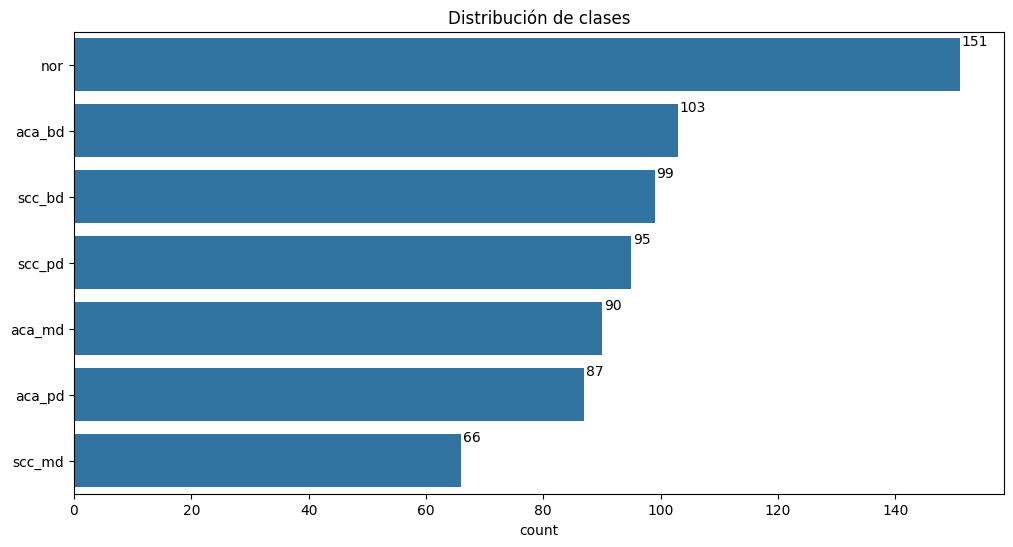

In [29]:
# ver distribución de clases, grafica de barras
plt.figure(figsize=(12, 6))
sns.countplot(y=labels, order=pd.Series(labels).value_counts().index)
#Mostrar conteos en las barras
for i in plt.gca().patches:
    plt.gca().text(i.get_width()+0.3, i.get_y()+0.1, str(int(i.get_width())), fontsize=10, color='black')
plt.title('Distribución de clases')

In [42]:
# Leer y almacenar las imágenes
img_data = []
for img_file in img_files:
    img = cv2.imread(img_file)
    if img is not None:
        img = np.array(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        img_data.append(img)
    else:
        print(f"No se pudo leer la imagen: {img_file}")

print(f"Total de imágenes cargadas: {len(img_data)}")
img_data = np.array(img_data)
print(f"Dimensiones del array de imágenes: {img_data.shape}")

Total de imágenes cargadas: 691
Dimensiones del array de imágenes: (691, 1200, 1600, 3)


# **2. Preparación**

Separamos las imagenes en los conjuntos de entrenamiento (70%), test (15%)y validación (15%)

In [51]:
X_train, X_temp, y_train_, y_temp = train_test_split(img_data, labels, test_size=0.30, random_state=RANDOM_SEED)
X_valid, X_test, y_valid_, y_test_ = train_test_split(X_temp, y_temp, test_size=0.50, random_state=RANDOM_SEED)
print(f"Tamaño del conjunto de entrenamiento: {len(X_train)}")
print(f"Tamaño del conjunto de validación: {len(X_valid)}")
print(f"Tamaño del conjunto de prueba: {len(X_test)}")

Tamaño del conjunto de entrenamiento: 483
Tamaño del conjunto de validación: 104
Tamaño del conjunto de prueba: 104


Ahora vamos a realizar One Hot a los lables

In [52]:
# Crear el encoder
encoder = LabelEncoder()

# Ajustar con todas las etiquetas disponibles
encoder.fit(labels)   # "labels" es tu vector original con todos los nombres de clases

# Transformar
y_train_enc = encoder.transform(y_train_)
y_valid_enc = encoder.transform(y_valid_)
y_test_enc  = encoder.transform(y_test_)

# One-hot encoding
y_train = to_categorical(y_train_enc)
y_valid = to_categorical(y_valid_enc)
y_test  = to_categorical(y_test_enc)


Reescalamos las imagenes a `TARGET_SIZE = (224, 224)`

In [53]:
TARGET_SIZE = (224, 224)
BATCH_SIZE = 32

# Reescalamos las imagenes antes de crear los generadores de imagenes
X_train_resized = tf.image.resize(X_train, TARGET_SIZE)
X_valid_resized = tf.image.resize(X_valid, TARGET_SIZE)
X_test_resized = tf.image.resize(X_test, TARGET_SIZE)

Se utilizan los generadores de datos de Keras para cargar las imágenes en tiempo real.

- Para el conjunto de entrenamiento se aplica data augmentation (rotación, volteo) para mejorar la robustez del modelo.
- Para validación y test, solo se reescala la imagen.

In [54]:
# Generador para entrenamiento con data augmentation
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    brightness_range=[0.9,1.1]
)

# Generador para validación y test (solo reescala)
test_val_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Creación de generadores 
train_gen = train_datagen.flow(
    x=X_train_resized,
    y=y_train,
    batch_size=BATCH_SIZE
)

val_gen = test_val_datagen.flow(
    x=X_valid_resized,
    y=y_valid,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_gen = test_val_datagen.flow(
    x=X_test_resized,
    y=y_test,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print(f"Number of batches in training generator: {len(train_gen)}")
print(f"Number of batches in validation generator: {len(val_gen)}")
print(f"Number of batches in test generator: {len(test_gen)}")

Number of batches in training generator: 16
Number of batches in validation generator: 4
Number of batches in test generator: 4


# **3. Modelamiento**

Recordemos las definiciones de nuestras capas:

- **Conv2D:** Aplica filtros aprendibles para extraer características de la imagen.
- **Pooling (MaxPooling2D):** Reduce la dimensión espacial, ayudando a la invariancia a traslaciones y reduciendo el cómputo. Existen otros tipos de pooling que también pueden implementar en la arquitectura como AveragePooling2D, GlobalMaxPooling2D y GlobalAveragePooling2D.
- **Flatten:** Convierte la salida multidimensional en un vector unidimensional.
- **Dense:** Capas completamente conectadas para la clasificación.
- **Dropout:** Regularización para prevenir el sobreajuste.

**Ahora usemos una red preentrenada como base y agregamos nuestro modelo secuencial**

In [55]:
num_classes = y_train.shape[1]

# Cargar la red InceptionResNetV2 preentrenada sin la parte superior (top)
base_model = InceptionResNetV2(
    input_shape=(224, 224, 3),
    weights='imagenet',
    include_top=False)

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

transfer_learning_model = Sequential(
    [
        base_model,
        GlobalAveragePooling2D(),  # Global Average Pooling
        Dense(32, activation='relu'),  # Capa densa
        Dropout(0.2),  # Capa de dropout
        Dense(16, activation='relu'),  # Capa densa
        Dense(num_classes, activation='softmax') # Capa de salida
    ]
)

# Compilar el modelo
transfer_learning_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Mostramos el resumen del modelo
transfer_learning_model.summary()


219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 18s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_resnet_v2             │ (None, 5, 5, 1536)     │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        49,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           119 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,386,567 (207.47 MB)

 Trainable params: 49,831 (194.65 KB)

 Non-trainable params: 54,336,736 (207.28 MB)

Se compila el modelo definiendo el optimizador, la función de pérdida y la métrica de evaluación. Utilizamos el optimizador **adam** y la función de pérdida **categorical_crossentropy** adecuada para clasificación multiclase.

**Callbacks**

In [64]:
# Model Checkpoint: Guarda el mejor modelo durante el entrenamiento.
model_checkpoint = ModelCheckpoint(MODELS_DIR / 'best_model.h5', save_best_only=True, monitor='val_loss', mode='min')

# EarlyStopping: Detiene el entrenamiento cuando una métrica monitoreada ha dejado de mejorar.
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')

# ReduceLROnPlateau: Reduce la tasa de aprendizaje cuando una métrica ha dejado de mejorar.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min')

# Lista de callbacks
callbacks = [model_checkpoint, early_stopping, reduce_lr]

In [65]:
# Callback extra
model_checkpoint_transfer_learning = ModelCheckpoint(MODELS_DIR / 'best_model_tl.h5', save_best_only=True, monitor='val_loss', mode='min')

callbacks_transfer_learning = [model_checkpoint_transfer_learning, early_stopping, reduce_lr]

**Entrenamos el modelo**

In [58]:
# Entrenar el modelo
with tf.device('/device:GPU:0'):
    history_transfer_learning = transfer_learning_model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=10,
        callbacks=callbacks_transfer_learning
    )

c:\Users\maril\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2217 - loss: 1.9769

16/16 ━━━━━━━━━━━━━━━━━━━━ 115s 6s/step - accuracy: 0.2070 - loss: 1.9509 - val_accuracy: 0.2308 - val_loss: 1.8915 - learning_rate: 0.0010
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1969 - loss: 1.9123

16/16 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.2133 - loss: 1.8866 - val_accuracy: 0.2596 - val_loss: 1.8663 - learning_rate: 0.0010
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2650 - loss: 1.8089

16/16 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.2629 - loss: 1.8187 - val_accuracy: 0.3462 - val_loss: 1.7463 - learning_rate: 0.0010
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2389 - loss: 1.8192

16/16 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.2795 - loss: 1.7984 - val_accuracy: 0.3558 - val_loss: 1.7132 - learning_rate: 0.0010
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.2712 - loss: 1.7958 - val_accuracy: 0.3558 - val_loss: 1.7362 - learning_rate: 0.0010
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.2981 - loss: 1.7421 - val_accuracy: 0.2788 - val_loss: 1.7229 - learning_rate: 0.0010
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2931 - loss: 1.7276

16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.2919 - loss: 1.7355 - val_accuracy: 0.3750 - val_loss: 1.6717 - learning_rate: 0.0010
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3248 - loss: 1.6895

16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.3023 - loss: 1.7212 - val_accuracy: 0.3462 - val_loss: 1.6475 - learning_rate: 0.0010
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3362 - loss: 1.6928

16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.3375 - loss: 1.6843 - val_accuracy: 0.4231 - val_loss: 1.6054 - learning_rate: 0.0010
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.3747 - loss: 1.6172 - val_accuracy: 0.4038 - val_loss: 1.6458 - learning_rate: 0.0010


A pesar de solo entrenarlo con 10 épocas tiene resultados decentes en términos de cantidad de imágenes, pues su entrenamiento demoró 20 minutos para más de 10000 imagenes

Ahora revisemos el **desempeño** de nuestro modelo:

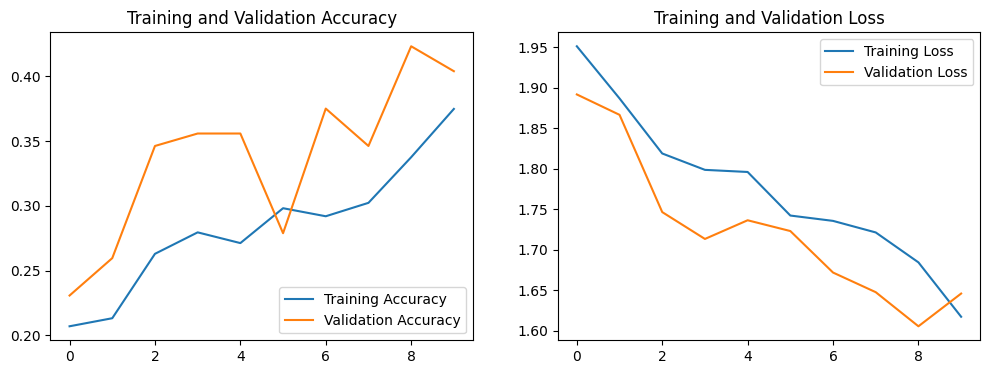

In [60]:
# Visualización de la progresión del entrenamiento

acc = history_transfer_learning.history['accuracy']
val_acc = history_transfer_learning.history['val_accuracy']
loss = history_transfer_learning.history['loss']
val_loss = history_transfer_learning.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

Ahora si **evaluemos** el modelo

In [61]:
# Evaluamos el modelo con nuestros datos de test
test_loss, test_acc = transfer_learning_model.evaluate(test_gen)

print('\nTest Accuracy:', test_acc)
print('Test Loss:    ', test_loss)

c:\Users\maril\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.3942 - loss: 1.6283

Test Accuracy: 0.39423078298568726
Test Loss:     1.6283208131790161


4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


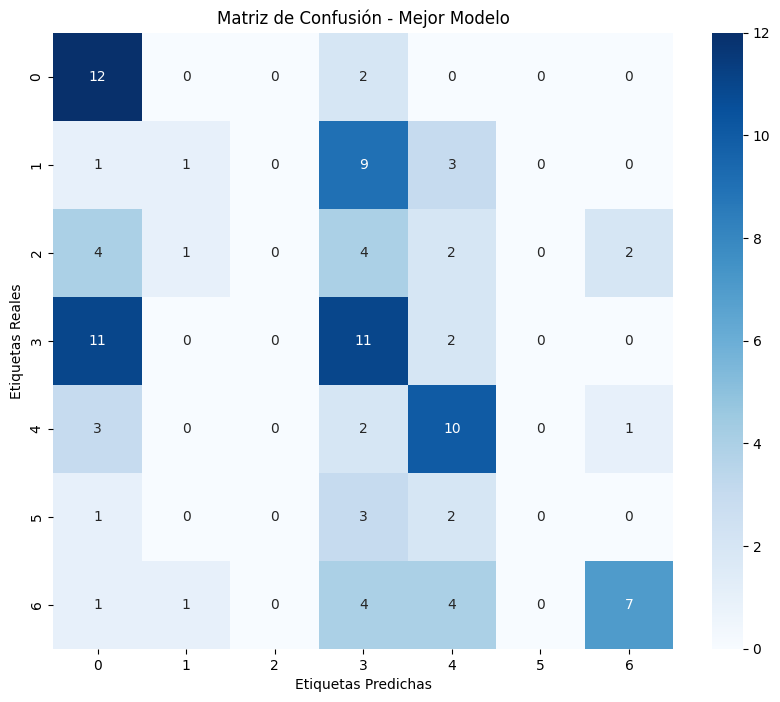

              precision    recall  f1-score   support

      aca_bd       0.36      0.86      0.51        14
      aca_md       0.33      0.07      0.12        14
      aca_pd       0.00      0.00      0.00        13
         nor       0.31      0.46      0.37        24
      scc_bd       0.43      0.62      0.51        16
      scc_md       0.00      0.00      0.00         6
      scc_pd       0.70      0.41      0.52        17

    accuracy                           0.39       104
   macro avg       0.31      0.35      0.29       104
weighted avg       0.35      0.39      0.33       104



c:\Users\maril\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\maril\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\maril\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

In [63]:
# Realizar predicciones
predicciones_tl = transfer_learning_model.predict(test_gen, verbose=1)

# Convertir las predicciones en etiquetas
y_pred_tl = np.argmax(predicciones_tl, axis=1)
y_test_r = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test_r, y_pred_tl)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.title('Matriz de Confusión - Mejor Modelo')
plt.ylabel('Etiquetas Reales')
plt.xlabel('Etiquetas Predichas')
plt.show()

print(classification_report(y_test_r, y_pred_tl, target_names=CLASS_NAMES))